### CNN - digits recognition

In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
import torch.nn.functional as F

**Create the DataLoaders**

In [2]:
# Mean and standard deviation of all the pixels in the MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,), (stddev_gray,))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [3]:
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray

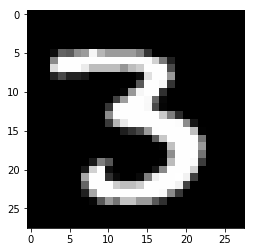

In [4]:
plt.imshow(img.reshape(28, 28), cmap='gray')
# Note that each image is 28 x 28 pixels

In [5]:
label = mnist_train[12][1]
label

3

In [6]:
batch_size = 1024 # Reduce this if you get out-of-memory error

In [7]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

**Create the model**

**Dropout**:

* A regularization technique: i.e. a technique to prevent overfitting, where the model becomes really good on the training dataset, but poor on the validation/testing dataset (unseen data)
* Randomly selected neurons are "switched off" or prevented from firing during each pass
* Thus, at every iteration, the model works with n% of it's neurons missing, where n is specified in the dropout layer (typically 0.5 or 50%)
* The result of this is that when random neurons are dropped, the alive neurons have to step in to generate the correct representation to decrease the loss function
* Thus the network becomes less sensitive to the weights of a selective few neurons, and become better at generalizing the features without overfitting the training data

Paper: [http://jmlr.org/papers/v15/srivastava14a.html](http://jmlr.org/papers/v15/srivastava14a.html)

![dropout.png](./dropout.png)

In [8]:
class MNISTNet(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        # which is what we are using.
        
        # Convolution Layer 1                             # 28 x 28 x 1  (input)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)     # 20 x 20 x 30  (after 2nd convolution)
        self.conv2_drop = nn.Dropout2d(p=0.5)             # Same as above
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 30  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(3000, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 3000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

**Create the objects**

In [9]:
# The model
net = MNISTNet()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

**Training loop**

In [10]:
num_epochs = 100

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.data[0] # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back-propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).data[0] # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    valid_accuracy.append(correct / len(mnist_valid_loader.dataset) * 100.0)

    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/100, Tr Loss: 1.0912, Tr Acc: 64.8150, Val Loss: 0.3349, Val Acc: 90.3600
Epoch 2/100, Tr Loss: 0.3399, Tr Acc: 89.9783, Val Loss: 0.2105, Val Acc: 93.6800
Epoch 3/100, Tr Loss: 0.2483, Tr Acc: 92.6450, Val Loss: 0.1625, Val Acc: 94.9800
Epoch 4/100, Tr Loss: 0.2048, Tr Acc: 93.8767, Val Loss: 0.1343, Val Acc: 95.9100
Epoch 5/100, Tr Loss: 0.1717, Tr Acc: 94.8750, Val Loss: 0.1185, Val Acc: 96.4300
Epoch 6/100, Tr Loss: 0.1549, Tr Acc: 95.4083, Val Loss: 0.1045, Val Acc: 96.8500
Epoch 7/100, Tr Loss: 0.1366, Tr Acc: 95.8583, Val Loss: 0.0953, Val Acc: 97.0400
Epoch 8/100, Tr Loss: 0.1248, Tr Acc: 96.2850, Val Loss: 0.0874, Val Acc: 97.1500
Epoch 9/100, Tr Loss: 0.1158, Tr Acc: 96.4650, Val Loss: 0.0808, Val Acc: 97.5200
Epoch 10/100, Tr Loss: 0.1077, Tr Acc: 96.7767, Val Loss: 0.0803, Val Acc: 97.5400
Epoch 11/100, Tr Loss: 0.0994, Tr Acc: 96.9867, Val Loss: 0.0744, Val Acc: 97.7100
Epoch 12/100, Tr Loss: 0.0952, Tr Acc: 97.2017, Val Loss: 0.0670, Val Acc: 97.8600
Epoch 13/100,

Epoch 100/100, Tr Loss: 0.0165, Tr Acc: 99.4183, Val Loss: 0.0291, Val Acc: 99.0400


In [11]:
torch.save(net.state_dict(), "./3.model.pth")

**Visialize the loss and accuracy**

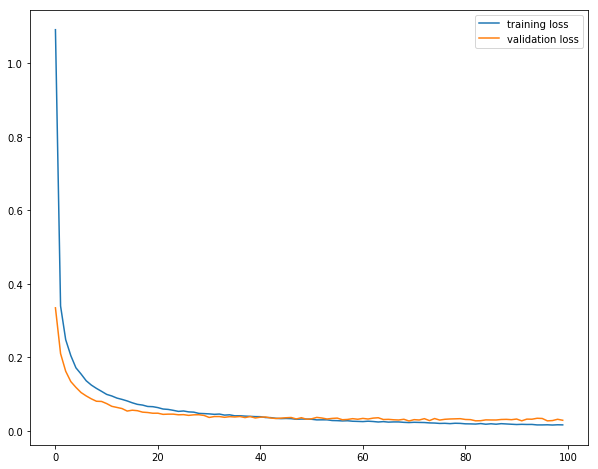

In [12]:
# Loss

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

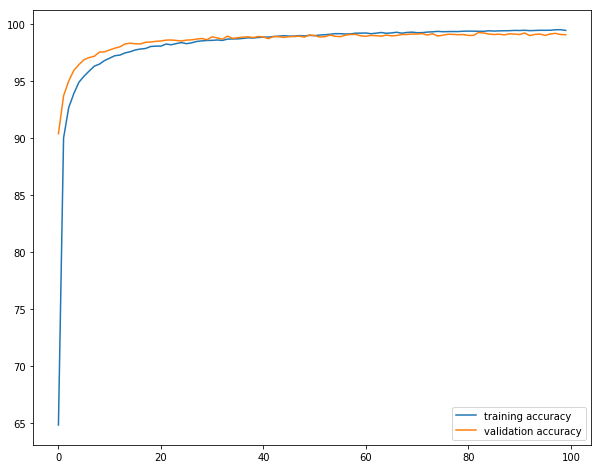

In [13]:
# Accuracy

f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

**Standalone inference**

In [14]:
image_index = 23
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]

net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)

In [15]:
output.data



Columns 0 to 7 
-11.0635  -8.2341  -8.3585  14.9212  -6.3458  31.9319   1.8713 -12.6704

Columns 8 to 9 
 -2.6972  12.8850
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

In [16]:
_, predicted = torch.max(output.data, 1)
print("Prediction is: ", predicted)

Prediction is:  
 5
[torch.cuda.LongTensor of size 1 (GPU 0)]



In [17]:
print("Actual is is: ", label)

Actual is is:  5


## things to explore

* Play with the various moving parts in this notebook and try to increase the accuracy
* Try a different dataset (http://pytorch.org/docs/master/torchvision/datasets.html)
* Try data augmentation (http://pytorch.org/docs/master/torchvision/transforms.html)